## XGBOOST Implementation

In [6]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
from numpy import std
from numpy import mean
import numpy as np
import os


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import roc_auc_score, auc, precision_recall_curve, roc_curve


### Select which model to run

#### Select side (right/left)  (only run one of the following two cells)

In [18]:
affected_side = 1
measured_side = 'right'

In [8]:
affected_side = 0
measured_side = 'left'

#### Select Speed

In [19]:
# Default Speed is Normal
# Speed = S - SLOW
#       = N - NORMAL
#       = F - FAST

Speed = "N"

measured_side_short = measured_side[0:1].upper()
if affected_side == 1:
    affected_side_name = 'right'
else:
    affected_side_name = 'left'

print('Running train/test normalized datasets and predictions for ' + measured_side + ' foot + ' + affected_side_name + ' knee injuries')

Running train/test normalized datasets and predictions for right foot + right knee injuries


# IMPORT DATA

### GAITREC Interpolated Data

In [20]:
## Import Interpolated HC and Knee OA data
gaitrec_hc = pd.read_csv('data/GaitREC/I_HC_' + measured_side_short + '_'+ Speed + '.csv')
gaitrec_affected = pd.read_csv('data/GaitREC/I_K_' + measured_side_short + '_N.csv')

gaitrec_all = pd.concat([gaitrec_hc, gaitrec_affected],axis=0)
gaitrec_remain = gaitrec_all[['SUBJECT_ID', 'CLASS_LABEL', 'AFFECTED_SIDE']]

### normalize using column-wise z-score

In [21]:
## Scaling Left Foot Data
gaitrec_nolabel = np.array(gaitrec_all.iloc[:,2:102], dtype=np.float64)

gaitrec_mean = np.mean(gaitrec_nolabel, axis=0)
gaitrec_std = np.std(gaitrec_nolabel, axis=0)

gaitrec_norm = (gaitrec_nolabel - gaitrec_mean)/gaitrec_std
gaitrec_norm = pd.DataFrame(gaitrec_norm)
gaitrec_norm = pd.concat((gaitrec_norm, gaitrec_remain.reset_index().drop(columns=['index'])),axis=1)

gaitrec_norm = gaitrec_norm[gaitrec_norm['AFFECTED_SIDE'] != (1-affected_side) ] # filter out opposite knee injuries
gaitrec_norm['CLASS_LABEL'].mask(gaitrec_norm['CLASS_LABEL'] == 'K', 1, inplace=True)
gaitrec_norm['CLASS_LABEL'].mask(gaitrec_norm['CLASS_LABEL'] == 'HC', 0, inplace=True)

# PyCaret Modeling

## Test-Train Split (85%-15%)

In [22]:
seed = 20
X_train, X_test = train_test_split(gaitrec_norm, test_size=0.15, random_state=seed)

X_train = X_train.set_index('SUBJECT_ID')
X_test = X_test.set_index('SUBJECT_ID')

X_train_gaitrec = X_train.copy().drop(columns=['AFFECTED_SIDE'])
X_test_gaitrec = X_test.copy().drop(columns=['AFFECTED_SIDE'])

X_train_gaitrec = np.array(X_train_gaitrec, dtype=np.float64)
X_test_gaitrec = np.array(X_test_gaitrec, dtype=np.int32)

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFwe, f_classif

np.random.seed(seed)
kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = seed)

exported_pipeline = make_pipeline(XGBClassifier(eval_metric='mlogloss'))

X = X_train_gaitrec[:,0:100]
y = X_train_gaitrec[:,100]
X_test_holdout = X_test_gaitrec[:,0:100]
y_test_holdout = X_test_gaitrec[:,100]

auROC_scores_valid = []
auPR_scores_valid = []
ids_cv = []
y_pred_cv = []
y_prob_cv = []
y_label_cv = []
for fold_n, (train_index, valid_index) in enumerate(kfold.split(X, y)):
    X_train_cv, X_valid_cv = X[train_index],X[valid_index]
    y_train_cv, y_valid_cv = y[train_index],y[valid_index]
    
    ids_cv.extend(list(X_train.index[valid_index]))
    
    exported_pipeline.fit(X_train_cv, y_train_cv)
    y_pred_valid = exported_pipeline.predict(X_valid_cv)
    y_prob_valid = [x[1] for x in exported_pipeline.predict_proba(X_valid_cv)]
    
    # ROC AUC
    auROC_fold_score = roc_auc_score(y_valid_cv, y_prob_valid)
    auROC_scores_valid.append(auROC_fold_score)
    
    # Precision-Recall AUC
    precision, recall, thresholds = precision_recall_curve(y_valid_cv, y_prob_valid)
    auPR_fold_score = auc(recall, precision)
    auPR_scores_valid.append(auPR_fold_score) 
    
    # Save predictions/probabilities
    y_prob_cv.extend(y_prob_valid)
    y_pred_cv.extend(y_pred_valid)
    y_label_cv.extend(y_valid_cv)
    
    print(fold_n + 1 , '\033[1mCV auROC = {0:.4f}, auPR = {0:.4f}'.format(auROC_fold_score, auPR_fold_score))

#print('CV mean auROC = {0:.4f}, sd = {0:.4f}'.format(np.mean(), np.std()))
#print('CV mean auPR = {0:.4f}, sd = {0:.4f}'.format(auROC_fold_score, auPR_fold_score))

exported_pipeline.fit(X,y)

print ("\n************************** \033[1mGAITREC VALIDATION DATA\033[0m Training(85%)) **************************")
print ("**************************     " + Speed + " - " + measured_side + "       *********************************************")
print("Samples per fold : ",len(X_valid_cv))
print("Total Number samples : ",len(X_train))
print(str(int(sum(y))) + ' cases')
print(str(len(y) - int(sum(y))) + ' controls')

print("\n\033[1mConfusion Matrix:\033[0m")
print(confusion_matrix(y_label_cv, y_pred_cv))
print("\n\033[1mClassification Report\033[0m")
print(classification_report(y_label_cv, y_pred_cv))

cv_fpr, cv_tpr, thresholds = roc_curve(y_label_cv, y_prob_cv)
print('\033[1mCV overall auROC score: {0:.4f}'.format(roc_auc_score(y_label_cv, y_prob_cv)))
cv_precision, cv_recall, thresholds = precision_recall_curve(y_label_cv, y_prob_cv)
print('\033[1mCV overall auPR score: {0:.4f}'.format(auc(recall, precision)))

print('\033[1mCV mean auROC score: {0:.4f}, std: {1:.4f}\033[0m'.format(np.mean(auROC_scores_valid), np.std(auROC_scores_valid)))
print('\033[1mCV mean auPR score: {0:.4f}, std: {1:.4f}\033[0m'.format(np.mean(auPR_scores_valid), np.std(auPR_scores_valid)))


print ("\n\n************************** \033[1mGAITREC TEST DATA\033[0m (15% of Total) *********************************************")
print ("**************************     " + Speed + " - " + measured_side + "       *********************************************")
#X_test = scaler.transform(X_test)
y_pred_holdout = exported_pipeline.predict(X_test_holdout)
y_prob_holdout = [x[1] for x in exported_pipeline.predict_proba(X_test_holdout)]
print("Number of Samples  : ",len(X_test))
print(str(int(sum(y_test_holdout))) + ' cases')
print(str(len(y_test_holdout) - int(sum(y_test_holdout))) + ' controls')

print("\n\033[1mConfusion Matrix:\033[0m")
print(confusion_matrix(y_test_holdout, y_pred_holdout))
print("\n\033[1mClassification Report\033[0m")
print(classification_report(y_test_holdout, y_pred_holdout))

test_fpr, test_tpr, thresholds = roc_curve(y_test_holdout, y_prob_holdout)
print('\033[1mtest auROC score: {0:.4f}'.format(roc_auc_score(y_test_holdout, y_prob_holdout)))
test_precision, test_recall, thresholds = precision_recall_curve(y_test_holdout, y_prob_holdout)
print('\033[1mtest auPR score: {0:.4f}'.format(auc(recall, precision)))


1 CV auROC = 0.8828, auPR = 0.8828
2 CV auROC = 0.9350, auPR = 0.9350
3 CV auROC = 0.9480, auPR = 0.9480
4 CV auROC = 0.9512, auPR = 0.9512
5 CV auROC = 0.9291, auPR = 0.9291

************************** GAITREC VALIDATION DATA Training(85%)) **************************
**************************     N - right       *********************************************
Samples per fold :  85
Total Number samples :  427
248 cases
179 controls

Confusion Matrix:
[[147  32]
 [ 30 218]]

Classification Report
              precision    recall  f1-score   support

         0.0       0.83      0.82      0.83       179
         1.0       0.87      0.88      0.88       248

    accuracy                           0.85       427
   macro avg       0.85      0.85      0.85       427
weighted avg       0.85      0.85      0.85       427

CV overall auROC score: 0.9257
CV overall auPR score: 0.9542
CV mean auROC score: 0.9292, std: 0.0246
CV mean auPR score: 0.9542, std: 0.0196


************************** G

# Moticon Dataset

### Import Moticon Interpolated Data

In [24]:
print('Running test predictions for ' + measured_side + ' foot in digital insole dataset (OA, HC)\n')

moticon_HC = pd.read_csv('data/Moticon/digital_insole_HC_vGRF_' + measured_side_short.lower() + '_' +  Speed.lower() + '.csv').drop(columns=['speed'])
moticon_HC['CLASS_LABEL'] = 0

moticon_OA = pd.read_csv('data/Moticon/digital_insole_OA_vGRF_' + measured_side_short.lower() + '.csv')
moticon_OA['CLASS_LABEL'] = 1

moticon = pd.concat([moticon_HC, moticon_OA], ignore_index = True)

moticon_remain = moticon[['ID', 'Injury', 'IDXKNEE', 'CLASS_LABEL']]

#print some stats about the dataset
print("Total Healthy Control Observations (walks):", len(moticon_HC))
print("Number of Unique Healthy Control Subjects:", len(set(moticon_HC['ID'])))
print("Total Osteo-Arthritis Clinical Observations (walks):", len(moticon_OA))
print("Number of Unique Osteo-Arthritis Clinical Subjects:",len(set(moticon_OA['ID'])))

len(moticon), set(moticon['CLASS_LABEL'])


Running test predictions for right foot in digital insole dataset (OA, HC)

Total Healthy Control Observations (walks): 21
Number of Unique Healthy Control Subjects: 21
Total Osteo-Arthritis Clinical Observations (walks): 35
Number of Unique Osteo-Arthritis Clinical Subjects: 35


(56, {0, 1})

### normalize using column-wise z-score

In [25]:
moticon_nolabel = moticon.drop(columns=['ID', 'Injury', 'IDXKNEE', 'CLASS_LABEL']) #moticon.iloc[:,0:-4]
moticon_nolabel = np.array(moticon_nolabel, dtype=np.float64)

moticon_mean = np.mean(moticon_nolabel, axis=0)
moticon_std = np.std(moticon_nolabel, axis=0)

X_moticon_norm = (moticon_nolabel - moticon_mean)/moticon_std
X_moticon_norm = pd.DataFrame(X_moticon_norm)
X_moticon_norm = pd.concat((X_moticon_norm,moticon_remain.reset_index().drop(columns=['index'])),axis=1)

### Testing Model on Moticon Data

In [26]:
data_unseen = X_moticon_norm # look at all knee injuries
data_unseen = data_unseen.drop('IDXKNEE', axis = 1)
label = data_unseen['CLASS_LABEL']

print ("\n\n************************** \033[1mMOTICON TEST DATA\033[0m (100% Moticon Data) *********************************************")
print ("**************************     " + Speed + " - " + measured_side + "       *********************************************")
#X_test_Moticon = scaler.transform(X_test_Moticon)
y_pred_test_Moticon = exported_pipeline.predict(data_unseen.iloc[:,0:100])
y_prob_test_Moticon = [x[1] for x in exported_pipeline.predict_proba(data_unseen.iloc[:,0:100])]

print("\n\033[1mConfusion Matrix:\033[0m")
print(confusion_matrix(label, y_pred_test_Moticon))
print("\n\033[1mClassification Report\033[0m")
print(classification_report(label, y_pred_test_Moticon))


moticon_fpr, moticon_tpr, thresholds = roc_curve(label, y_prob_test_Moticon)
print('\033[1mtest auROC score: {0:.4f}'.format(roc_auc_score(label, y_prob_test_Moticon)))
moticon_precision, moticon_recall, thresholds = precision_recall_curve(label, y_prob_test_Moticon)
print('\033[1mtest auPR score: {0:.4f}'.format(auc(moticon_recall, moticon_precision)))




************************** MOTICON TEST DATA (100% Moticon Data) *********************************************
**************************     N - right       *********************************************

Confusion Matrix:
[[18  3]
 [11 24]]

Classification Report
              precision    recall  f1-score   support

           0       0.62      0.86      0.72        21
           1       0.89      0.69      0.77        35

    accuracy                           0.75        56
   macro avg       0.75      0.77      0.75        56
weighted avg       0.79      0.75      0.75        56

test auROC score: 0.8585
test auPR score: 0.9091


## Plot Results

In [17]:
from plotnine import ggplot, geom_line, scale_color_manual, theme_bw, geom_abline, xlab, geom_hline, aes, ylim


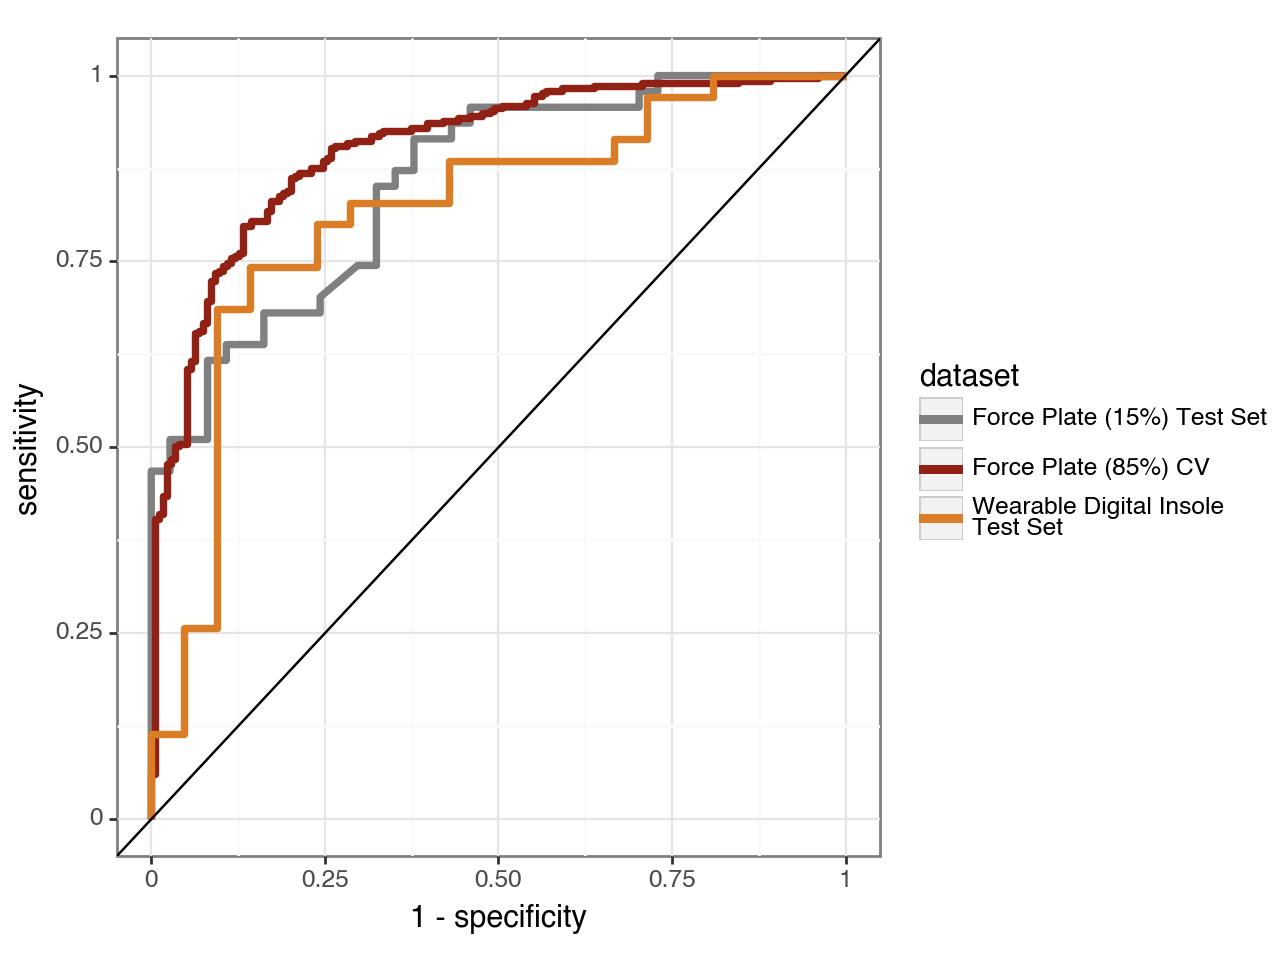

In [23]:
roc_data = pd.concat([
    pd.DataFrame({'fpr' : cv_fpr, 'sensitivity' : cv_tpr, 'dataset' : 'Force Plate (85%) CV'}),
    pd.DataFrame({'fpr' : test_fpr, 'sensitivity' : test_tpr, 'dataset' : 'Force Plate (15%) Test Set'}),
    pd.DataFrame({'fpr' : moticon_fpr, 'sensitivity' : moticon_tpr, 'dataset' : 'Wearable Digital Insole\nTest Set'})
    ])

print(
    ggplot(roc_data, aes(x = "fpr", y= "sensitivity", color = "dataset"))
    + geom_line(size = 1.5)
    + scale_color_manual(["grey", "#922115", "#DB7C26"])
    + theme_bw()
    + geom_abline(intercept = 0, slope = 1)
    + xlab('1 - specificity')
)


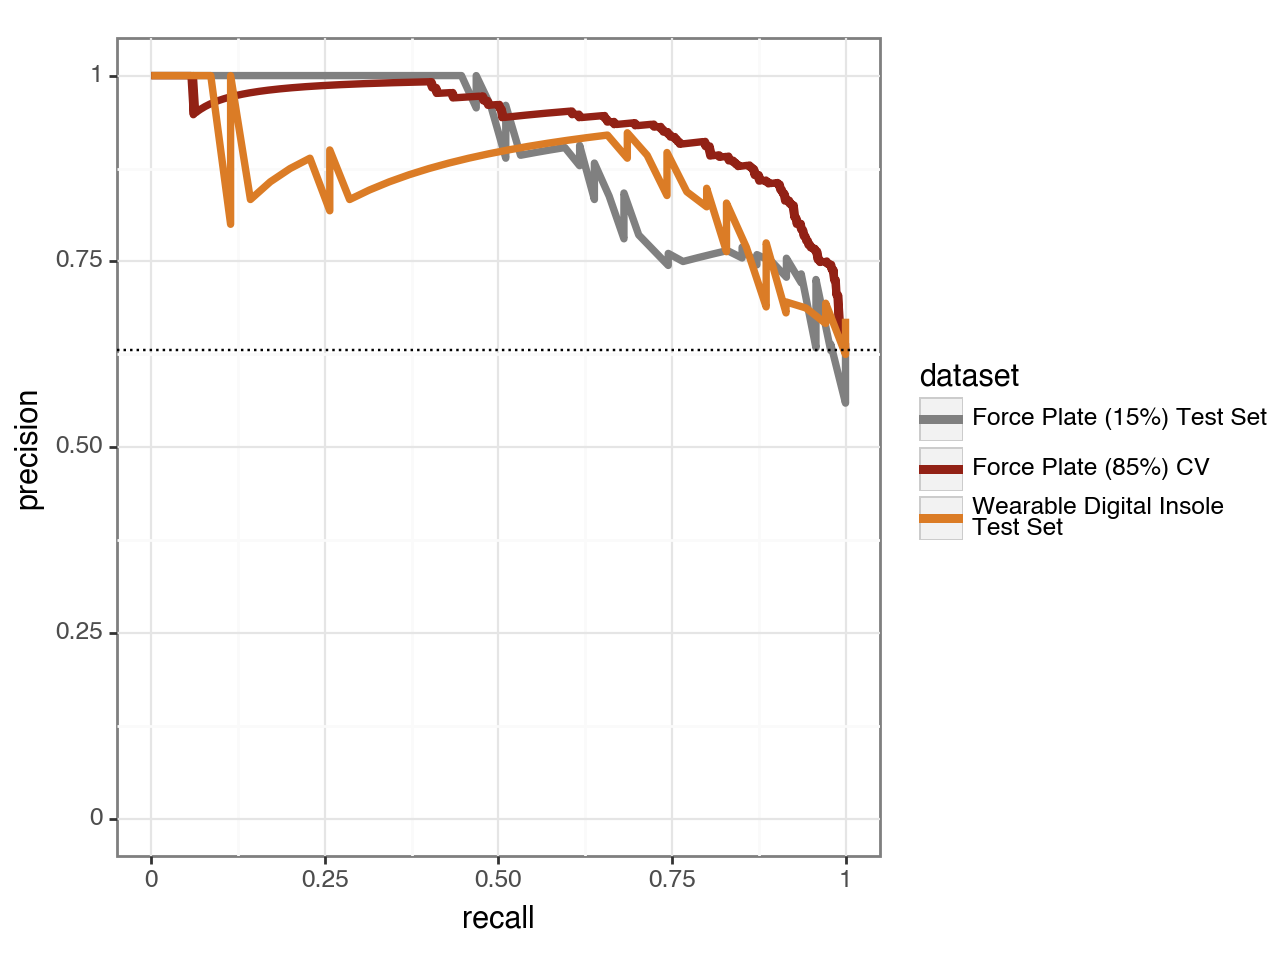

In [24]:
pr_data = pd.concat([
    pd.DataFrame({'precision' : cv_precision, 'recall' : cv_recall, 'dataset' : 'Force Plate (85%) CV'}),
    pd.DataFrame({'precision' : test_precision, 'recall' : test_recall, 'dataset' : 'Force Plate (15%) Test Set'}),
    pd.DataFrame({'precision' : moticon_precision, 'recall' : moticon_recall, 'dataset' : 'Wearable Digital Insole\nTest Set'})
    ])

print(
    ggplot(pr_data, aes(x = "recall", y= "precision", color = "dataset"))
    + geom_line(size = 1.5)
    + scale_color_manual(["grey","#922115", "#DB7C26"])
    + theme_bw()
    + ylim(0,1)
    + geom_hline(yintercept =  sum(y_label_cv) / len(y_label_cv), linetype = "dotted")
)
